<center>

# King James Bible Dataset Analysis
### Author: Tadeáš Tomiška
<br>

</center>

<p style="text-align: justify;">
The King James Bible (KJB), also known as the Authorized Version (AV), is an English translation of the Christian Bible first published in 1611. It is one of the most widely read and influential works in the English language. In this study, we will focus specifically on the Torah, which comprises the first five books of the Old Testament: Genesis, Exodus, Leviticus, Numbers, and Deuteronomy. Our analysis will begin with a basic exploration of the dataset, including:
</p>

* Counting the number of verses per book
* Analyzing the similarity between books

<p style="text-align: justify;">
Once the initial analysis is complete, we will apply machine learning and deep learning techniques to assign each verse to its corresponding book within the Torah. The goal is to predict the book for each verse based on its content and structure.
</p>


## Data

<p style="text-align: justify;">
The dataset used in this analysis is the full text of the King James Bible, excluding the deuterocanonical books. The text is stored in  `data/bible.txt`, and each row in the file represents a single verse from the Bible. The structure of each row is as follows:
</p>

* book name
* [one space]
* chapter number
* [:]
* verse number
* [one tab character]
* verse text

For example:
<p style="text-align: justify;">
Genesis 1:1 &emsp; In the beginning God created the heaven and the earth.
</p>


## Data Preparation

<p style="text-align: justify;">
Fortunately, we do not need to perform any data cleaning for this analysis. The King James Bible dataset is already well-structured and free of any missing or corrupted data. Let´s load the dataset and take a look at the first few rows:
</p>

In [2]:
import pandas as pd

# Define a function to parse the book, chapter, and verse
def parse_reference(reference):
    book, chapter_verse = reference.rsplit(' ', 1)
    chapter, verse = map(int, chapter_verse.split(':'))
    return book, chapter, verse

# Load the data
file_path = "data/bible.txt"
data = pd.read_csv(file_path, header=None, sep="\t", names=["Book Chapter:Verse", "Text"])
data["Book"], data["Chapter"], data["Verse"] = zip(*data["Book Chapter:Verse"].apply(parse_reference))
data = data[["Book", "Chapter", "Verse", "Text"]]

# Display the resulting DataFrame
data.head()

,Book,Chapter,Verse,Text
0,Genesis,1,1,In the beginning God created the heaven and th...
1,Genesis,1,2,"And the earth was without form, and void; and ..."
2,Genesis,1,3,"And God said, Let there be light: and there wa..."
3,Genesis,1,4,"And God saw the light, that it was good: and G..."
4,Genesis,1,5,"And God called the light Day, and the darkness..."


<p style="text-align: justify;">
Now, let's extract the Torah books from the dataset, which are the first five books of the Old Testament: Genesis, Exodus, Leviticus, Numbers, and Deuteronomy.
</p>

In [3]:
import numpy as np

np.random.seed(42)
torah_books = ["Genesis", "Exodus", "Leviticus", "Numbers", "Deuteronomy"]
torah_data = data[data["Book"].isin(torah_books)]

print(f"Old Testament books count: {len(torah_books)}")
print(f"Old Testament verses count: {len(torah_data)}")

Old Testament books count: 5
Old Testament verses count: 5852


### Count of Verses per Book
<p style="text-align: justify;">
Let´s analyze the number of verses in each Torah book and visualize the results using a bar chart and a pie chart.
</p>

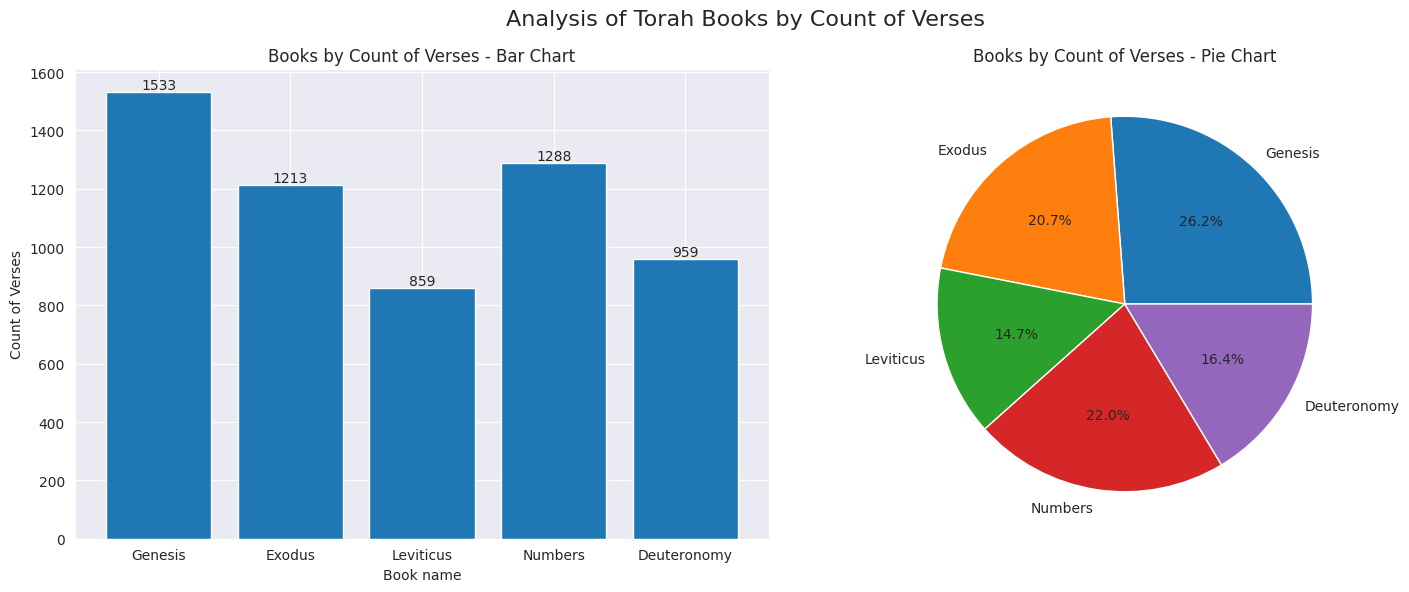

In [4]:
from matplotlib import pyplot as plt

# Filter data for Old Testament books
verse_counts = torah_data.groupby("Book").size()
ordered_verse_counts = verse_counts.reindex(torah_books)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Analysis of Torah Books by Count of Verses", fontsize=16)

# Plot the bar chart on the first subplot
bars = axes[0].bar(ordered_verse_counts.index, ordered_verse_counts)
axes[0].set_title("Books by Count of Verses - Bar Chart")
axes[0].set_xlabel("Book name")
axes[0].set_ylabel("Count of Verses")

# Add the verse count numbers to each bar
for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, yval + 10, int(yval), ha='center')

# Plot the pie chart on the second subplot
axes[1].pie(ordered_verse_counts, autopct='%1.1f%%', labels=ordered_verse_counts.index)
axes[1].set_title("Books by Count of Verses - Pie Chart")

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

<p style="text-align: justify;">
As we can see, the count of verses is quite well distributed across the books. No book contains two times more verses than another. Book Genesis has the most verses, while Leviticus has the least.
</p>

### Similarity Between Torah Books
<p style="text-align: justify;">
To analyze the similarity between Torah books, we'll use TF-IDF to convert the text into numerical vectors and compute cosine similarity to measure how similar the books are.
</p>


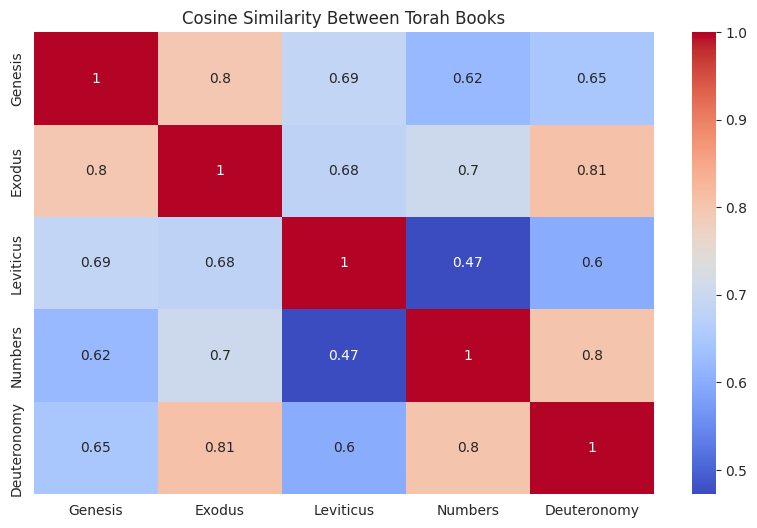

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare vectorizer and texts
vectorizer = TfidfVectorizer(stop_words="english", lowercase=True)
books_text = torah_data.groupby("Book")["Text"].apply(" ".join).to_dict()

# Compute cosine similarity
tfidf_matrix = vectorizer.fit_transform(books_text.values())
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=torah_books, columns=torah_books)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(similarity_df, annot=True, cmap="coolwarm", cbar=True, xticklabels=torah_books, yticklabels=torah_books)
plt.title("Cosine Similarity Between Torah Books")
plt.show()

<p style="text-align: justify;">
We can see that Leviticus stands out as the least similar to the other books, which suggests that predictions for its verses are likely to be more accurate, as its content is unique. On the other hand, Exodus and Deuteronomy are very similar to two other books, making it harder to predict the correct book for verses from these books. This overlap in content could result in lower prediction accuracy.
</p>

## Machine Learning and Deep Learning Models
<p style="text-align: justify;">
In this section, we apply machine learning and deep learning models to predict the book based on verse. We aim to evaluate various models and select the best one.
</p>

### Machine Learning
<p style="text-align: justify;">
We will start with traditional machine learning models, such as Support Vector Machines, Multinomial Naive Bayes, Gradient Boosting Classifier and Multiclass Logistic Regression. The text data will be transformed using TF-IDF vectorizer.
</p>

#### Prepare Train and Test Data
<p style="text-align: justify;">
We will divide data into training and testing sets, with 70% allocated for training and 30% for testing. The text data and labels are converted to NumPy arrays for compatibility with machine learning workflows. Additionally, a mapping is created to assign unique numeric identifiers to each book in from Torah.
</p>


In [6]:
from sklearn.model_selection import train_test_split

data = torah_data["Text"].to_numpy()
book_label_mapping = {book: idx for idx, book in enumerate(torah_books)}
labels = torah_data["Book"].map(book_label_mapping).to_numpy()

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

#### Check bias
<p style="text-align: justify;">
Let´s visualize the distribution of labels in the training set and compare it with the expected distribution based on the original dataset. This helps in identifying any biases in the label distribution when splitting the data.
</p>


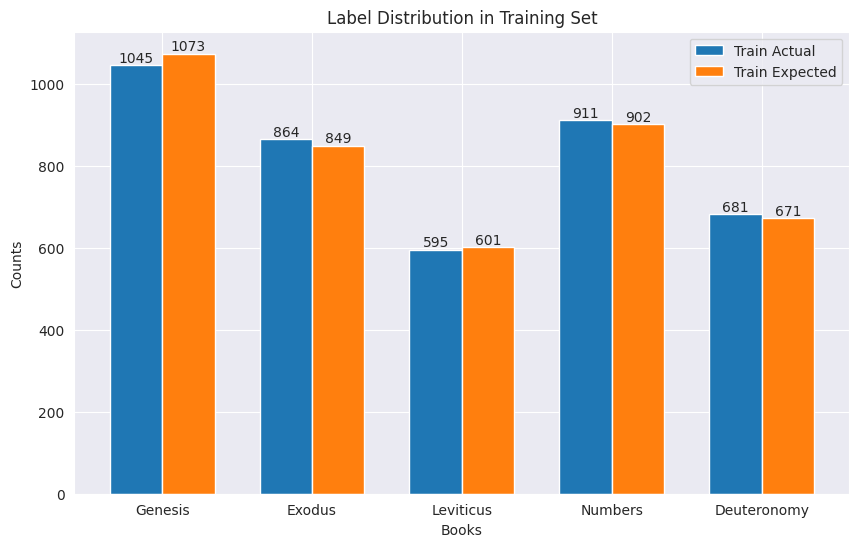

In [7]:
from collections import Counter

# Calculate counts and expected values
original_counts = Counter(labels)
train_counts = Counter(train_labels)
expected_train_counts = {label: original_counts[label] * 0.7 for label in original_counts}

# Prepare data for plotting
train_actual_counts = [train_counts.get(label, 0) for label in range(len(torah_books))]
train_expected_counts = [expected_train_counts.get(label, 0) for label in range(len(torah_books))]

# Plotting
x = np.arange(len(torah_books))
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bars_actual = ax.bar(x - bar_width / 2, train_actual_counts, bar_width, label='Train Actual')
bars_expected = ax.bar(x + bar_width / 2, train_expected_counts, bar_width, label='Train Expected')

for bar in bars_actual + bars_expected:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.0f}', va='bottom', ha='center')

ax.set(xlabel='Books', ylabel='Counts', title='Label Distribution in Training Set')
ax.set_xticks(x)
ax.set_xticklabels(book for book in torah_books)
ax.legend()
plt.show()

<p style="text-align: justify;">
We can see that the distribution of labels across the training set is well-balanced and aligns closely with the expected proportions derived from the original dataset. This suggests that there is no noticeable bias in the way the data has been split.
</p>

#### Base Estimators
<p style="text-align: justify;">
This function provides base estimators for machine learning models with default hyperparameters.
</p>



In [8]:
import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.neural_network
import sklearn.svm

def get_base_estimator(model: str):
    if model == "svm":
        return sklearn.svm.SVC()
    elif model == "mnb":
        return sklearn.naive_bayes.MultinomialNB()
    elif model == "gbc":
        return sklearn.ensemble.GradientBoostingClassifier()
    elif model == "mlr":
        return sklearn.linear_model.LogisticRegression()
    else:
        raise ValueError("Unknown model {}".format(model))

#### Training Script
<p style="text-align: justify;">
We will train a text classification model using a pipeline with TfidfVectorizer and the specified estimator. N-grams in the vectorizer represent sequences of 1 to 3 consecutive words. We will return model's training and testing accuracies.
</p>


In [9]:
import sklearn.feature_extraction
import sklearn.pipeline
from sklearn.metrics import accuracy_score

def machine_learning(estimator, train_data, train_labels, test_data, test_labels) -> [float, float]:
    # Train the model
    features = sklearn.feature_extraction.text.TfidfVectorizer(analyzer="word", lowercase=False, ngram_range=(1,3))
    model = sklearn.pipeline.Pipeline([("Features", features), ("Estimator", estimator)])
    model.fit(train_data, train_labels)

    # Evaluate the model
    train_accuracy = accuracy_score(model.predict(train_data), train_labels)
    test_accuracy = accuracy_score(model.predict(test_data), test_labels)
    return train_accuracy, test_accuracy

#### Plot Accuracies
<p style="text-align: justify;">
This function plots training and testing accuracies for different models using bar charts. It prepares the data, creates bars for each model, and annotates the bars with accuracy values. The plot displays training vs testing accuracy for each model, with a legend and axis labels.
</p>


In [10]:
def prepare_accuracies(results):
    # Prepare the data for plotting
    train_accuracies = [results[model][0] * 100 for model in results]
    test_accuracies = [results[model][1] * 100 for model in results]
    return train_accuracies, test_accuracies


def plot_bars(x, train_accuracies, test_accuracies, bar_width):
    # Create bar plots for training and testing accuracy
    train_bars = plt.bar(x, train_accuracies, width=bar_width, label='Training Accuracy', color='skyblue')
    test_bars = plt.bar([i + bar_width for i in x], test_accuracies, width=bar_width, label='Testing Accuracy', color='lightgreen')
    return train_bars, test_bars


def annotate_bars(bars):
    # Annotate the accuracy values at the top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, f'{yval:.1f}%', ha='center', va='bottom')


def plot_accuracies(results):
    train_accuracies, test_accuracies = prepare_accuracies(results)

    # Plot the results
    x = range(len(results))
    plt.figure(figsize=(10, 6))
    bar_width = 0.35

    # Plot bars
    train_bars, test_bars = plot_bars(x, train_accuracies, test_accuracies, bar_width)

    # Add labels, title, and legend
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.title("Training vs Testing Accuracy of Models")
    plt.xticks([i + bar_width / 2 for i in x], results.keys())
    plt.legend()

    # Annotate bars
    annotate_bars(train_bars)
    annotate_bars(test_bars)

    # Display the graph
    plt.yticks(range(0, 101, 5))
    plt.tight_layout()
    plt.show()

#### Run Base Models
<p style="text-align: justify;">
This script runs a set of base machine learning models and evaluates their performance on the provided training and testing data. Convergence warnings are suppressed to avoid cluttering the output. The accuracies of all models are plotted, and the model with the highest testing accuracy is identified as the best model.
</p>


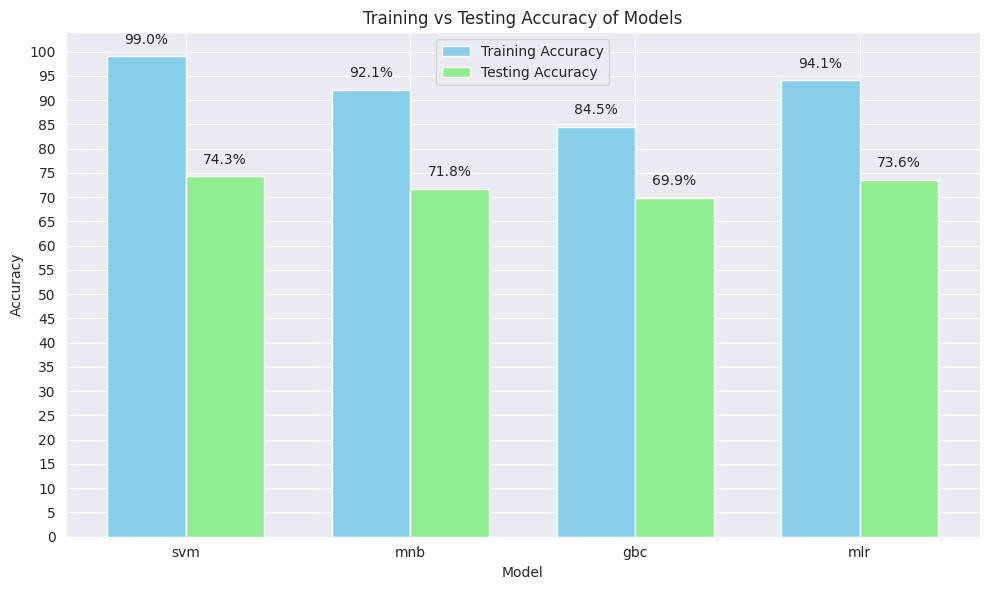

Best model: svm with testing accuracy: 0.74


In [11]:
from sklearn.exceptions import ConvergenceWarning
import warnings

# Ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Run the machine learning models
models = ["svm", "mnb", "gbc", "mlr"]
data = [train_data, train_labels, test_data, test_labels]
estimators = [get_base_estimator(model) for model in models]
no_hyperparameter_results = {model: machine_learning(estimator, *data) for model, estimator in zip(models, estimators)}
plot_accuracies(no_hyperparameter_results)

# get best model
best_model = max(no_hyperparameter_results, key=lambda x: no_hyperparameter_results[x][1])
print(f"Best model: {best_model} with testing accuracy: {no_hyperparameter_results[best_model][1]:.2f}")

<p style="text-align: justify;">
The best-performing model is Support vector machine, with an accuracy of 74%. While all models achieved high accuracy on the training dataset, the testing accuracy is considerably lower, which suggests overfitting. To address this, we will attempt to improve the models by tuning their hyperparameters.
</p>

#### Tuned Estimators
<p style="text-align: justify;">
This code returns a tuned versions of machine learning models with a bit optimized hyperparameters for better performance.
</p>

In [12]:
def get_tuned_estimator(model: str):
    if model == "svm":
        return sklearn.svm.SVC(kernel="rbf", gamma=0.1)
    elif model == "mnb":
        return sklearn.naive_bayes.MultinomialNB(alpha=10)
    elif model == "gbc":
        return sklearn.ensemble.GradientBoostingClassifier(n_estimators=20, max_depth=3)
    elif model == "mlr":
        return sklearn.linear_model.LogisticRegression(solver="saga", penalty="elasticnet", l1_ratio=0.5)
    else:
        raise ValueError("Unknown model {}".format(model))

#### Run Tuned Models
<p style="text-align: justify;">
This script runs machine learning models with optimized hyperparameters and evaluates their performance. The accuracies are plotted, and the model with the highest testing accuracy is selected as the best model.
</p>

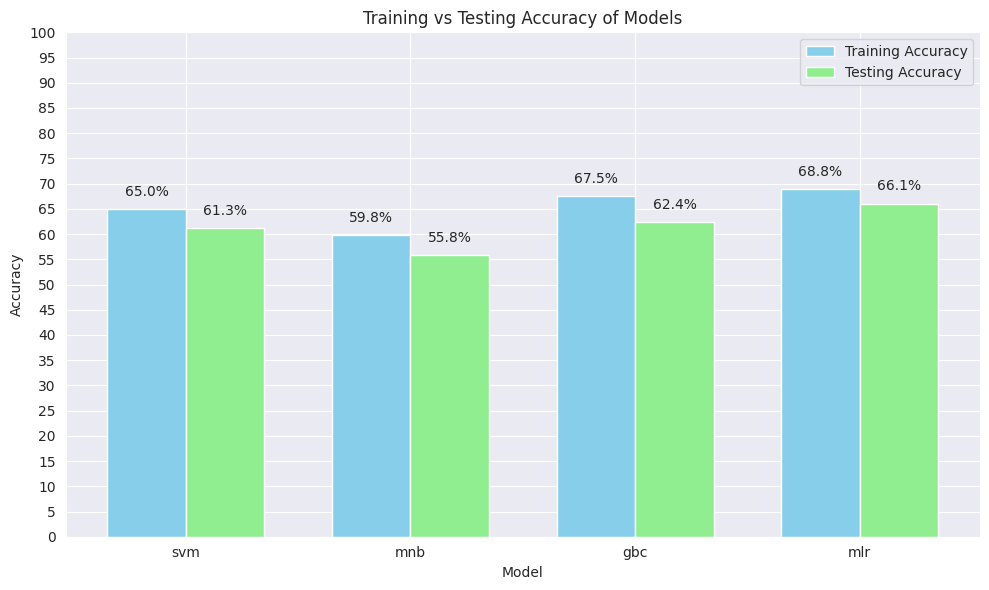

Best model: mlr with testing accuracy: 0.66


In [13]:
# Run the machine learning models
estimators = [get_tuned_estimator(model) for model in models]
no_hyperparameter_results = {model: machine_learning(estimator, *data) for model, estimator in zip(models, estimators)}
plot_accuracies(no_hyperparameter_results)

# get best model
best_model = max(no_hyperparameter_results, key=lambda x: no_hyperparameter_results[x][1])
print(f"Best model: {best_model} with testing accuracy: {no_hyperparameter_results[best_model][1]:.2f}")

<p style="text-align: justify;">
This time, the gap between training and testing accuracy is much smaller, suggesting that the models are not overfitting. However, it's worth noting that the testing accuracy for all models is lower compared to the results without hyperparameter tuning. Despite this fact, these models are more generalized and probably more reliable. The best-performing model is the multiclass logistic regression, achieving an accuracy of 66%.
</p>

### Deep Learning
<p style="text-align: justify;">
    In this section, we will explore a state-of-the-art approach using deep learning. Specifically, we will utilize the <strong>Bible-roberta-base</strong> model, a specialized variant of the BERT architecture, renowned for its exceptional performance across a wide range of natural language processing (NLP) tasks. This variant of model was trained for one epoch on datasets comprising seven English Bible translations, allowing it to capture linguistic and contextual nuances specific to biblical text. For more details, you can refer to the official repository: <a href="https://huggingface.co/abhi1nandy2/Bible-roberta-base/blob/main/README.md" target="_blank">Bible-roberta-base on Hugging Face</a>.
</p>


#### Dataset
<p style="text-align: justify;">
    This script defines a custom dataset class BibleDataset for use with PyTorch. It stores encoded text data and labels, and implements the necessary methods for data access and iteration:
</p>
<ul>
    <li><code>__len__</code> (returns the number of samples)</li>
    <li><code>__getitem__</code> (retrieves a specific sample by index)</li>
</ul>



In [14]:
from torch.utils.data import Dataset

class BibleDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

#### Prepare Datasets
<p style="text-align: justify;">
This script loads a tokenizer for the specified model, calculates the maximum text length, and tokenizes the training and testing data. It then creates custom BibleDataset instances for the training and testing data.
</p>

In [15]:
from transformers import AutoTokenizer

# Load tokenizer and get maximum length
model_id = "abhi1nandy2/Bible-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
max_length = torah_data["Text"].apply(len).max()

# Prepare encodings
train_encodings = tokenizer(list(train_data), padding="max_length", max_length=max_length)
test_encodings = tokenizer(list(test_data), padding="max_length", max_length=max_length)

# Create datasets
train_dataset = BibleDataset(train_encodings, train_labels)
test_dataset = BibleDataset(test_encodings, test_labels)

#### Save Model After Each Epoch
<p style="text-align: justify;">
We will also define a custom SaveCallback that saves a copy of the model after each epoch during training. The saved models are stored in a list and can be accessed with the <code>get_saved_models()</code> method.
</p>


In [16]:
import copy
from transformers import TrainerCallback

class SaveCallback(TrainerCallback):
    # Callback to store models after each epoch
    def __init__(self):
        self._saved_models = []

    def get_saved_models(self):
        return self._saved_models

    def on_epoch_end(self, args, state, control, **kwargs):
        model = copy.deepcopy(kwargs['model'])
        self._saved_models.append(model)

#### Training Arguments and Trainer
<p style="text-align: justify;">
This code defines functions to create training arguments and a trainer for model training. The <code>get_training_arguments</code> function configures hyperparameters such as learning rate, number of epochs, and logging strategies. The <code>get_trainer</code> function sets up the <code>Trainer</code> with the model, datasets, and callback for saving the model after each epoch.
</p>


In [17]:
from transformers import Trainer, TrainingArguments

def get_training_arguments(temp_dir, learning_rate, num_train_epochs, verbose):
    return TrainingArguments(
        output_dir=temp_dir,
        learning_rate=learning_rate,
        num_train_epochs=num_train_epochs,
        disable_tqdm=not verbose,
        eval_strategy="epoch",
        logging_strategy='epoch',
    )

def get_trainer(model, training_args, train_dataset, test_dataset, save_callback):
    return Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        callbacks=[save_callback],
    )

#### Model Implementation
<p style="text-align: justify;">
This function trains a deep learning model for sequence classification. It initializes the model, sets training arguments, and trains the model for a specified number of epochs.
</p>

In [18]:
import os
import tempfile
import torch
from transformers import AutoModelForSequenceClassification, logging

def train_dl_model(model_id, train_dataset, test_dataset, save_callback, num_labels, epochs, lr, verbose):
    torch.manual_seed(42)
    logging.set_verbosity_error()

    # Suppress tokenizers parallelism warning
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)

    with tempfile.TemporaryDirectory() as temp_dir:
        # Load trainer
        training_args = get_training_arguments(temp_dir, lr, epochs, verbose)
        trainer = get_trainer(model, training_args, train_dataset, test_dataset, save_callback)
        trainer.train()

#### Train Deep Learning Model
<p style="text-align: justify;">
Let´s train a deep learning model using the specified parameters, including the number of labels, epochs, learning rate, and verbosity. We will also save the model after each epoch using the SaveCallback.
</p>

In [19]:
save_callback = SaveCallback()
parameters = {"num_labels": len(torah_books), "epochs": 4, "lr": 1e-5, "verbose": True}
train_dl_model(model_id, train_dataset, test_dataset, save_callback, **parameters)

Epoch,Training Loss,Validation Loss
1,1.060500,0.819182
2,0.657200,0.681116
3,0.487500,0.682128
4,0.380800,0.679029


<p style="text-align: justify;">
We can see that the training loss decreases steadily, showing the model is learning. However, from epoch 2, the validation loss starts to stagnate, suggesting potential overfitting, where the model improves on training data but struggles to generalize to unseen data. Let´s check accuracies.
</p>

#### Evaluate Saved Models
<p style="text-align: justify;">
We will evaluate saved models on training and testing datasets, with accuracies calculated for each. We will then plot accuracies to compare performance across epochs.
</p>

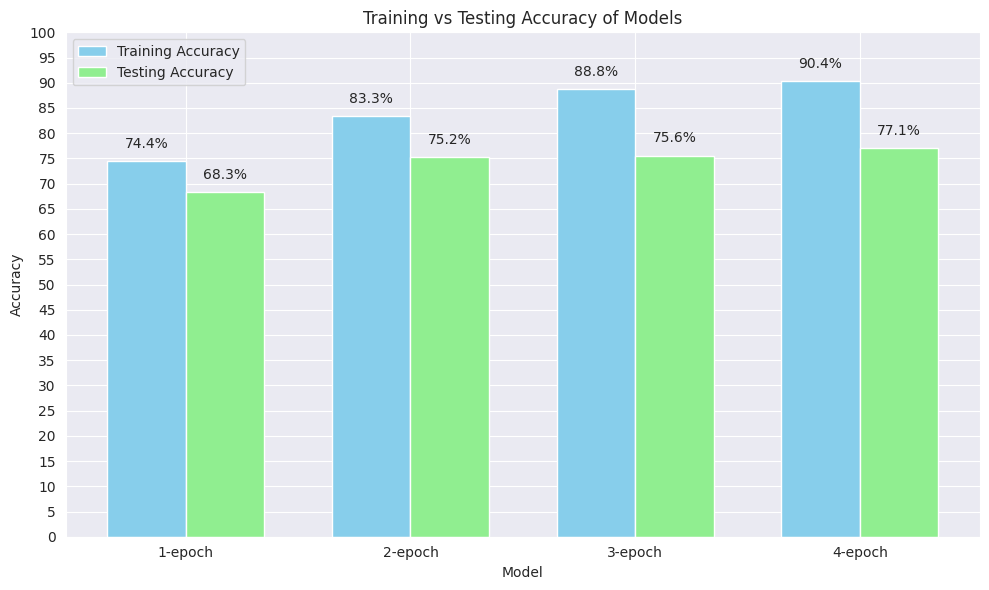

In [20]:
# get saved models
results = {}
saved_models = save_callback.get_saved_models()

for index, model in enumerate(saved_models):
    trainer = Trainer(model=model)
    train_predictions = trainer.predict(train_dataset).predictions
    test_predictions = trainer.predict(test_dataset).predictions

    # Get the accuracy for the sets
    train_accuracy = accuracy_score(np.argmax(train_predictions, axis=1), train_labels)
    test_accuracy = accuracy_score(np.argmax(test_predictions, axis=1), test_labels)
    results[f"{index + 1}-epoch"] = (train_accuracy, test_accuracy)

# Plot accuracies
plot_accuracies(results)

<p style="text-align: justify;">
Our observation based on the validation loss was correct: from epoch 2, the model starts to overfit, with the gap between training and testing accuracy widening. Although the model achieves the highest accuracy at epoch 4, the model trained for 2 epochs could be the better choice, as it might be able to generalize better to unseen data. Let´s check accuracies for individual classes for 2-epoch and 4-epoch models.
</p>

#### Class-wise Accuracy
<p style="text-align: justify;">
This function calculates the class-wise accuracy for a given model and test dataset. The accuracy for each class is calculated as the ratio of correct predictions to total instances, and the results are displayed for each Torah book.
</p>

In [21]:
def calculate_class_accuracies(model, test_dataset, test_labels):
    class_accuracies = {}
    class_counts = Counter(test_labels)

    # Get predictions from the model
    trainer = Trainer(model=model)
    predictions = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

    for label in class_counts:
        class_indices = [i for i, test_label in enumerate(test_labels) if test_label == label]
        class_predictions = [predictions[i] for i in class_indices]
        correct_predictions = sum(1 for pred in class_predictions if pred == label)
        class_accuracy = correct_predictions / class_counts[label]
        class_accuracies[label] = class_accuracy

    return class_accuracies

#### Plot Accuracy per Class
<p style="text-align: justify;">
Let’s visualize the class-wise accuracies for the models trained for 2 epochs and 4 epochs. Based on the similarity matrix, we expect higher accuracy for Leviticus and comparatively lower accuracy for Exodus and Deuteronomy.
</p>

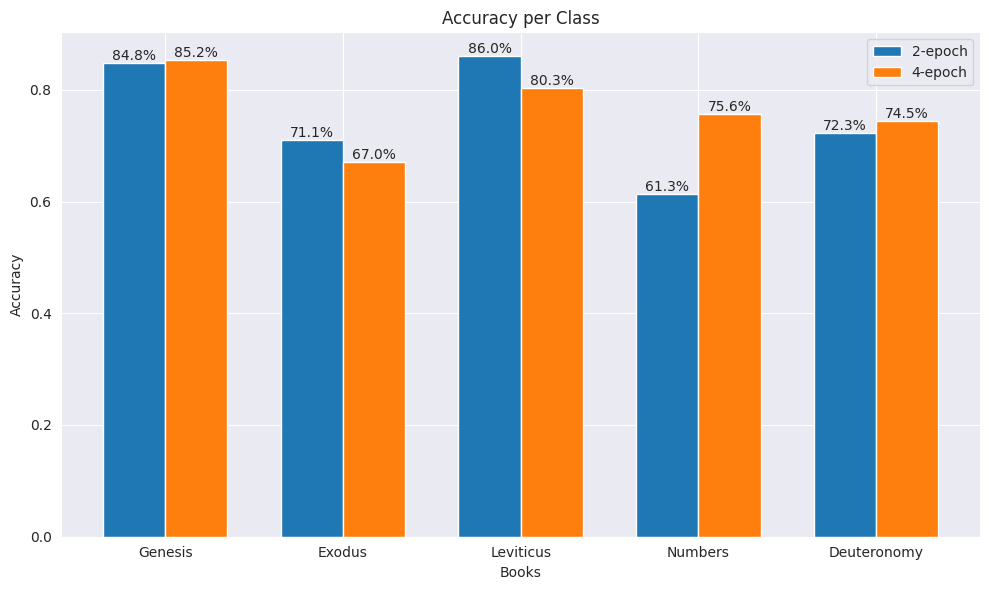

In [22]:
models = [saved_models[1], saved_models[3]]
accuracies = {}

for model, name in zip(models, ["2-epoch", "4-epoch"]):
    class_accuracies = calculate_class_accuracies(model, test_dataset, test_labels)
    accuracies[name] = sorted(class_accuracies.items(), key=lambda x: x[0])

# Prepare data for plotting
x = np.arange(len(torah_books))
bar_width = 0.35
model_1_accuracies = [accuracy for label, accuracy in accuracies["2-epoch"]]
model_3_accuracies = [accuracy for label, accuracy in accuracies["4-epoch"]]

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_1 = ax.bar(x - bar_width / 2, model_1_accuracies, bar_width, label='2-epoch')
bar_2 = ax.bar(x + bar_width / 2, model_3_accuracies, bar_width, label='4-epoch')

for bar in bar_1 + bar_2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval * 100:.1f}%', va='bottom', ha='center')

# Customize and display the plot
ax.set(xlabel='Books', ylabel='Accuracy', title='Accuracy per Class', xticks=x)
ax.set_xticklabels(book for book in torah_books)
ax.legend()
plt.tight_layout()
plt.show()

<p style="text-align: justify;">
Both models demonstrate high accuracy for the book of Leviticus, as anticipated. Additionally, Genesis shows very good accuracy, while the lower accuracy for Exodus and Deuteronomy aligns with our expectations. However, the most notable drawback of the 2-epoch model is the significant drop in accuracy for Numbers. Let’s take a closer look at the predictions to understand why.
</p>

### Plotting Count of Predictions per Class
<p style="text-align: justify;">
This code plots the count of predictions per class for the 2-epoch and 4-epoch models on the test dataset. We also plot the true label counts for comparison.
</p>

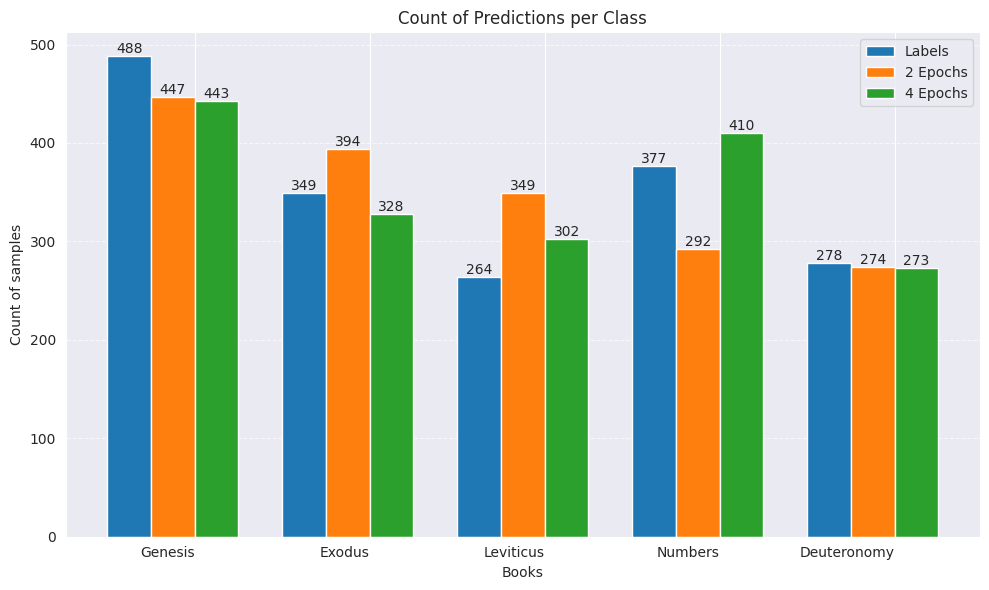

In [23]:
# Initialize trainers
class_counts = Counter(test_labels)
num_labels = [class_counts[label] for label in range(len(torah_books))]
trainers = {
    "2 Epochs": Trainer(model=saved_models[1]),
    "4 Epochs": Trainer(model=saved_models[3]),
}

# Get predictions and counts for each model
pred_counts = {
    name: Counter(np.argmax(trainer.predict(test_dataset).predictions, axis=1))
    for name, trainer in trainers.items()
}

# Prepare data for plotting
x = np.arange(len(torah_books))
bar_width = 0.25

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
label_bars = ax.bar(x - bar_width, num_labels, bar_width, label='Labels')
for i, (name, counts) in enumerate(pred_counts.items()):
    pred_bars = ax.bar(x + i * bar_width, [counts[label] for label in range(len(torah_books))], bar_width, label=name)

    # Add text values to prediction bars
    for bar in pred_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

# Add text values to label bars
for bar in label_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

# Customize the plot
ax.set(xlabel='Books', ylabel='Count of samples', title='Count of Predictions per Class')
ax.set_xticks(x + 0.125, torah_books, rotation=0, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The 2-epoch model predicts that a verse belongs to the book of Numbers only 292 times, even though it was given 377 verses from this book. This explains the model’s low accuracy for Numbers. In contrast, the 4-epoch model’s predictions are more closely aligned with the true labels, suggesting it performs better. Although there is a notable 13% gap between its training and test accuracy, the 4-epoch model may still deliver strong results.

## Conclusion
<p style="text-align: justify;">
We analyzed the King James Bible dataset and experimented with several machine learning models to predict the Torah book based on a verse. The best performing tuned model was logistic regression, achieving an accuracy of 66%. We then explored a deep learning approach using a variant of the BERT language model, which performed quite well, reaching an accuracy of 75% after 2 epochs and 77% after 4 epochs. It is important to note that we did not conduct extensive hyperparameter tuning, as this was not the primary goal of the project. There is surely room for improvement in each model with more thorough hyperparameter optimization.
</p>

<p style="text-align: justify;">
An interesting next step in this project would be to explore ensemble methods, combining models like the trained logistic regression and the 2-epoch and 4-epoch deep learning models. Additionally, another extension could involve experimenting with the recently released <a href="https://huggingface.co/docs/transformers/main/model_doc/modernbert" target="_blank">Modern BERT</a> model. Although I initially planned to use this model, I encountered an issue with <a href="https://discuss.huggingface.co/t/modernbert-maskedlm-nan-training-loss/133951" target="_blank">NaN train loss</a>, which prevented its use. Once this issue is resolved, it would be interesting to experiment with this model.
</p>



## References
<p style="text-align: justify;">
<a href="https://aclanthology.org/2021.semeval-1.87/">cs60075_team2 at SemEval-2021 Task 1 : Lexical Complexity Prediction using Transformer-based Language Models pre-trained on various text corpora</a> (Nandy et al., SemEval 2021)
</p>
